# Dengue prediction model

In this notebook I develop a machine learning model to predict dengue cases reported each week in San Juan, Puerto Rico and Iquitos, Peru. 

Dengue is an infectious diseases

As per the challenge link, sata has been collected by "_various U.S. Federal Government agencies—from the Centers for Disease Control and Prevention to the National Oceanic and Atmospheric Administration in the U.S. Department of Commerce_"

In [1]:
%load_ext autoreload
%autoreload 2

# Importing the libraries

In [2]:
import pandas as pd
import klib
import numpy as np
import matplotlib.pyplot as plt

# Reading the datasets

The datasets can be found at this https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/data/

I have saved the data locally on my machine for convenience

In [3]:
X_train = pd.read_csv("../../data/training_features.csv")
y_train = pd.read_csv("../../data/training_labels.csv")

# For simplicity, we create a single dataset
df = X_train.merge(y_train)

# Sort values for convenience
df = df.sort_values(by=["city", "week_start_date"]).reset_index(drop=True)

X_test = pd.read_csv("../../data/test_features.csv")

Each row represents a week of environmental data (weather + vegetation) for two cities. The reported number of dengue cases is also there

In [4]:
X_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


According to the problem description here, we have 4 categories of features https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/

First thing for me was to understand the difference between NOAA (The National Oceanic and Atmospheric Administration) GHCN (lobal Historical Climatology Network) and reanalysis NCEP (National Centers for Environmental Prediction).

Here it looks like that reanalysis is a kind of interpolation of past data using predictive weather models https://www.ecmwf.int/en/about/media-centre/focus/2020/fact-sheet-reanalysis

Apart from the informtion about city and time of the year, we have 4 groups of features

In [5]:
# Small hack 
df.rename(columns={"reanalysis_tdtr_k": "reanalysis_temp_rng_k" }, inplace=True)
X_train.rename(columns={"reanalysis_tdtr_k": "reanalysis_temp_rng_k" }, inplace=True)
X_test.rename(columns={"reanalysis_tdtr_k": "reanalysis_temp_rng_k" }, inplace=True)

end =  "\n\n" + "*"*150 +  "\n "

print(end)

precipitation = list(df.filter(regex="precip").columns)
print("Precipitation columns:", precipitation,  end)


temperature = list(df.filter(regex="temp").columns)
print(f"Temperature columns:", temperature, end)


humidity = list(df.filter(regex="humidity").columns)
print(f"Humidity columns:", humidity, end)


vegetation = list(df.filter(regex="ndvi").columns)
print("Satellite vegetation columns:", vegetation, end)



******************************************************************************************************************************************************
 
Precipitation columns: ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm'] 

******************************************************************************************************************************************************
 
Temperature columns: ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_temp_rng_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'] 

******************************************************************************************************************************************************
 
Humidity columns: ['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg'] 

******************

In [6]:
# Check no repeating columns
all_columns = temperature + precipitation + humidity + vegetation
len(all_columns) == len(set(all_columns))

True

In [7]:
# Check that we have included all columns, but city and time related ones
set(X_train.columns).difference(set(all_columns))

{'city', 'week_start_date', 'weekofyear', 'year'}

It is to be noticed that we hostorical  weather data. The test set on which I am requested to make predictions includes both, however if I were to produce a model able to predict dengue cases in the future, actual data will not be avaialble, so I might exclude those

In [8]:
# TO DO: Address later!

# Preliminary exploration

What we can see from the plot below:
- No column has a lot of null values
- There are about 10 rows with a lot of nulls values
- The remaining rows have null values clustered in a feature group: might be worth imputing them with a regression (always be careful to data leakage)
- The are few sizable blocks of null data. As we are dealing time series, it can be sensible to just interpolate linearly the series

In [9]:
df.insert(0, "_city", None)
df.loc[df["city"] == "sj", "_city"] = 1

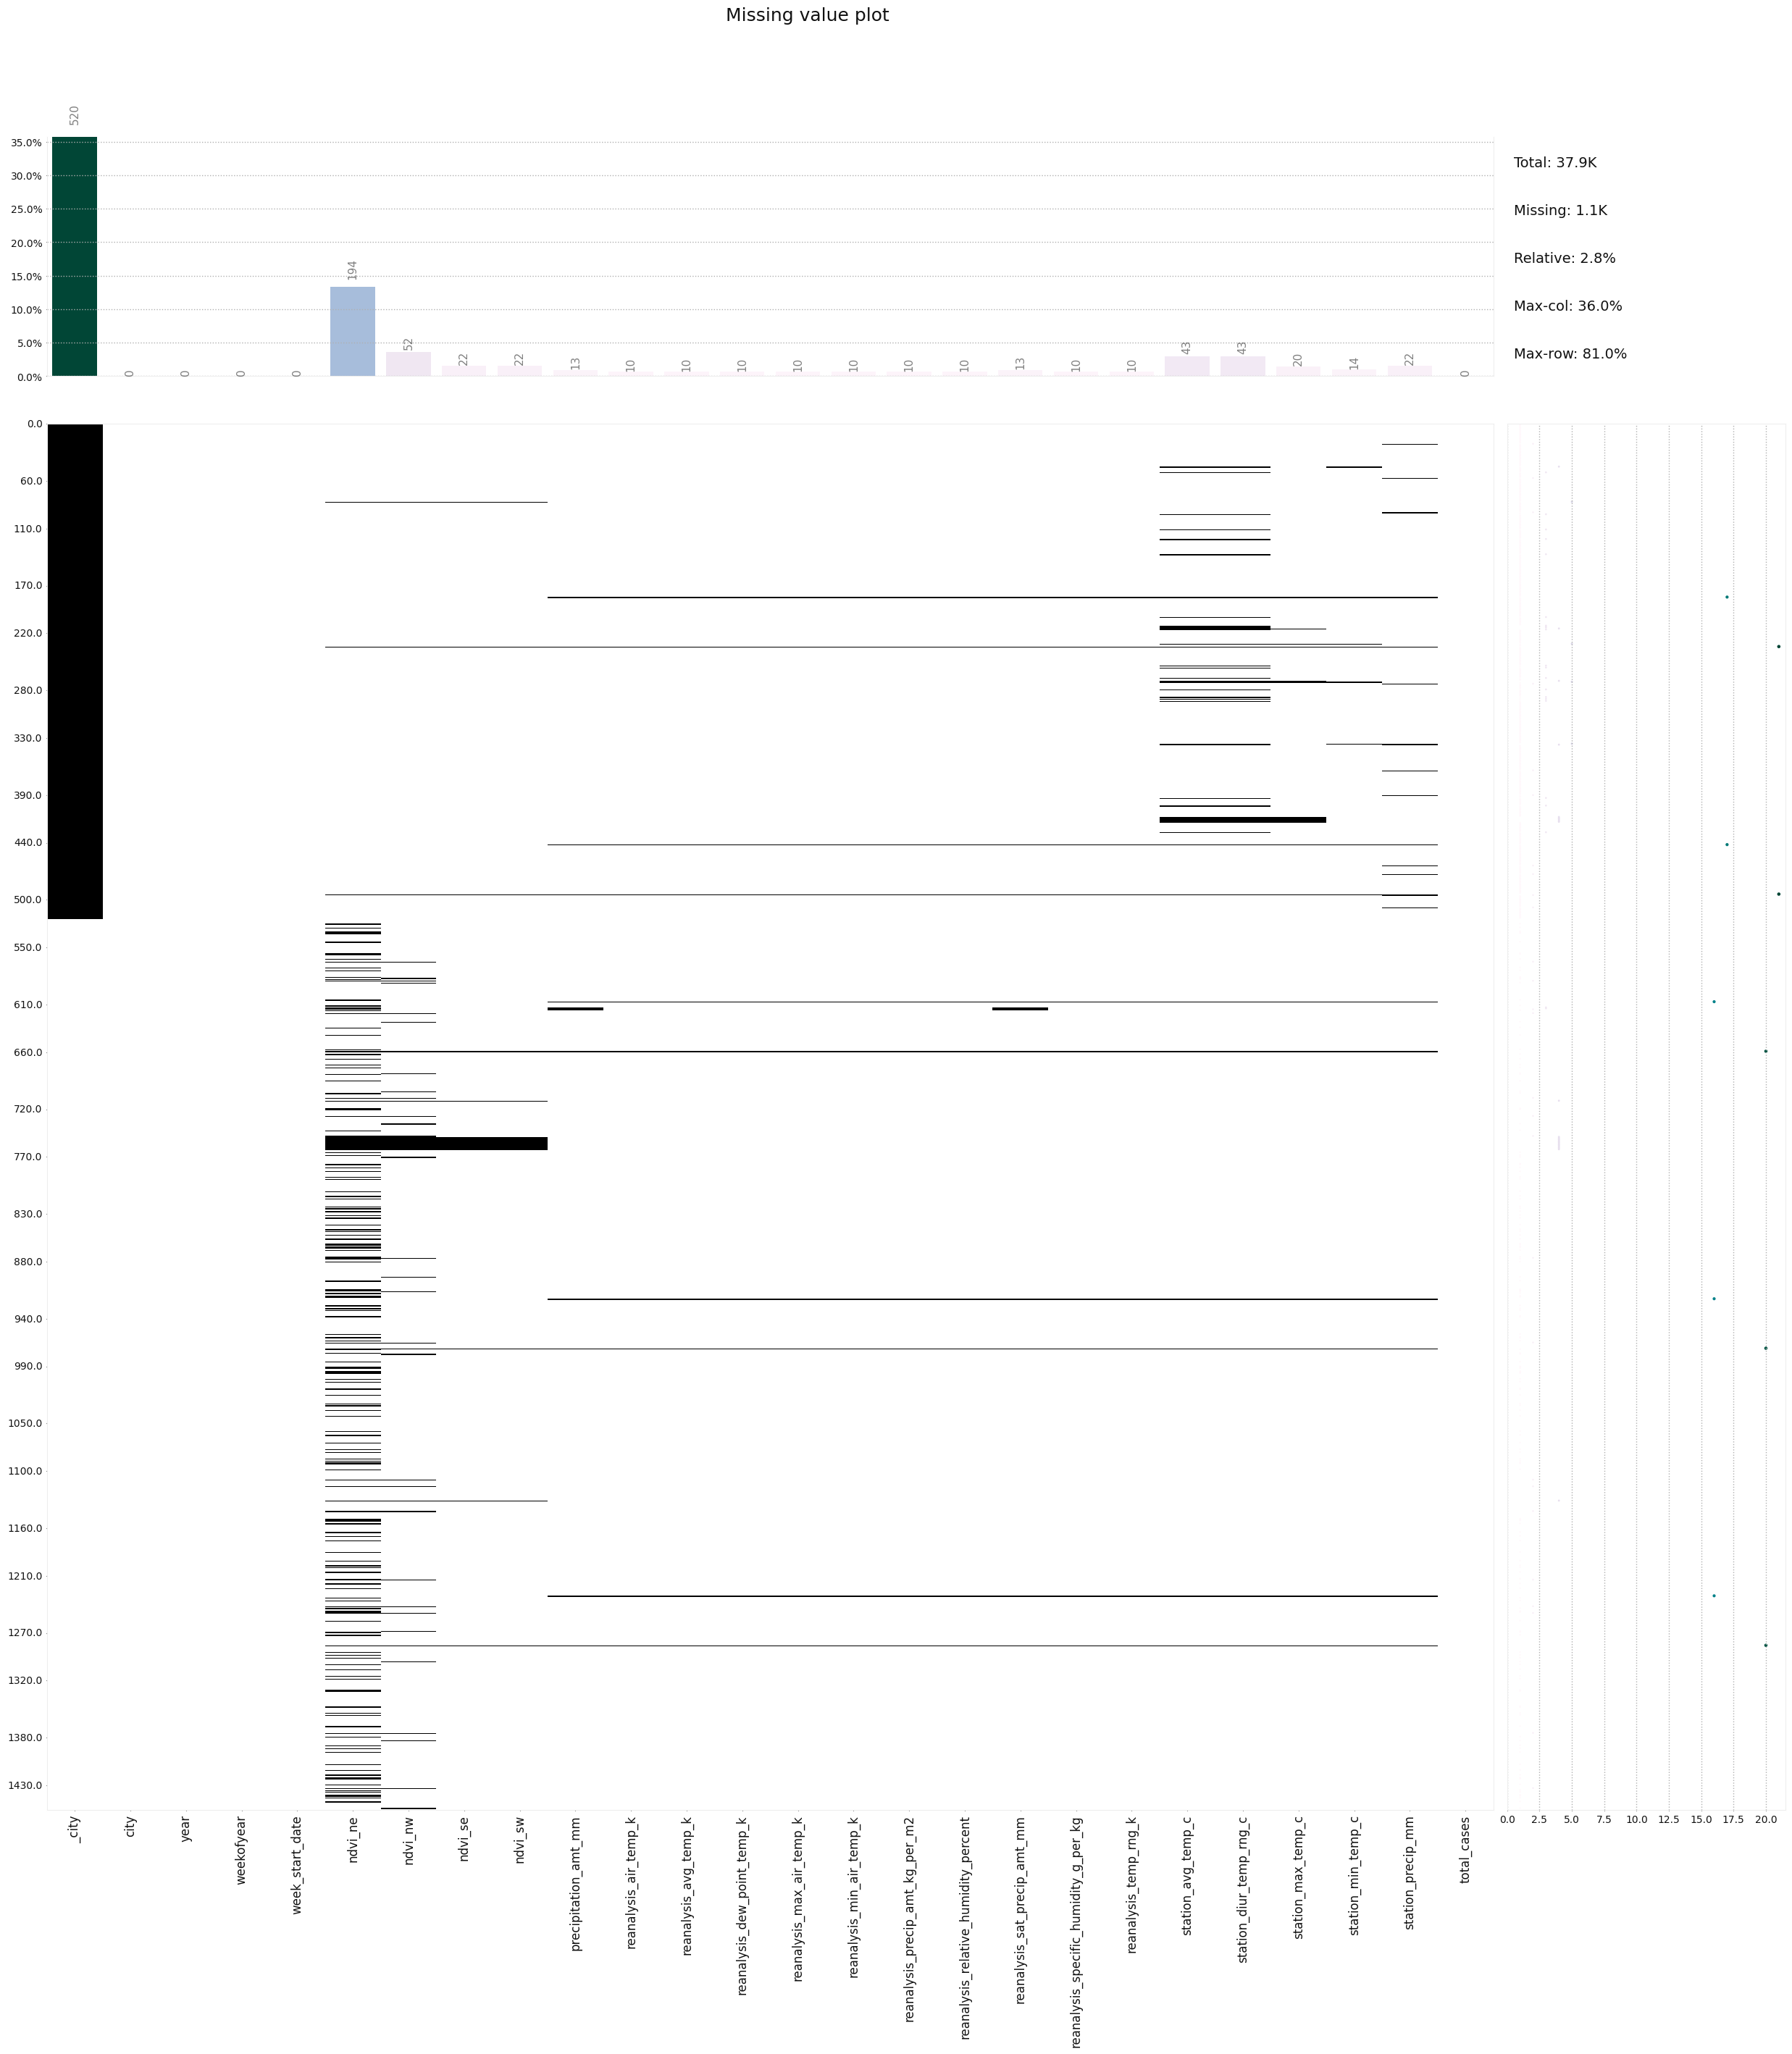

In [10]:
# Missing values 
klib.missingval_plot(df, figsize=(30, 30))
plt.show()

In [11]:
df.drop(columns="_city", inplace=True)

In [12]:
df.dropna(thresh=df.shape[1] - 15, inplace=True)

Vegetation is the one with more null values

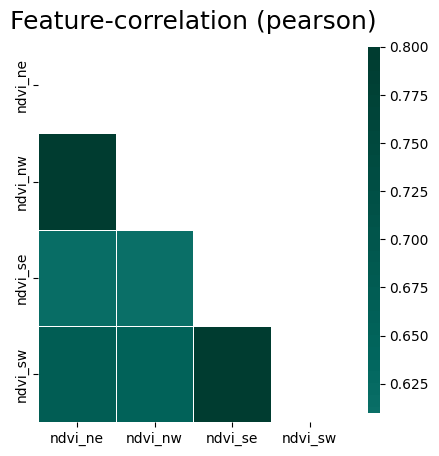

In [13]:
klib.corr_plot(df[vegetation], annot=False, figsize=(5, 5))
plt.show()

In [14]:
from dengue_prediction.preprocessing.cleaning import fill_nulls

In [15]:
df[vegetation].isna().sum()

ndvi_ne    189
ndvi_nw     47
ndvi_se     17
ndvi_sw     17
dtype: int64

In [16]:
df = fill_nulls(df, vegetation)

Nulls are reduced

In [17]:
df[vegetation].isna().sum()

ndvi_ne    33
ndvi_nw    33
ndvi_se    17
ndvi_sw    17
dtype: int64

We do some inputing by hand

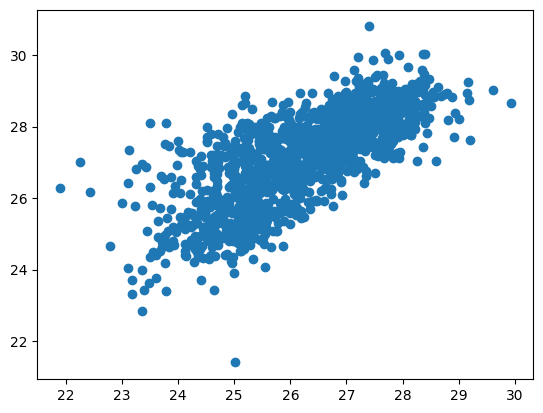

In [18]:
plt.scatter(df["reanalysis_avg_temp_k"] - 273, df["station_avg_temp_c"])

In [19]:
df["station_max_temp_c"].fillna(df["reanalysis_max_air_temp_k"] - 273, inplace=True)
df["station_min_temp_c"].fillna(df["reanalysis_min_air_temp_k"] - 273, inplace=True)

In [20]:
df["station_avg_temp_c"].fillna(0.5*(df["station_max_temp_c"] + df["station_min_temp_c"]), inplace=True)
df["station_diur_temp_rng_c"].fillna(df["station_max_temp_c"] - df["station_min_temp_c"], inplace=True)

In [21]:
df[df[temperature].isna().any(axis=1)]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_temp_rng_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases


In [22]:
# Precipitation

In [23]:
df[precipitation].isna().sum()

precipitation_amt_mm                3
reanalysis_precip_amt_kg_per_m2     0
reanalysis_sat_precip_amt_mm        3
station_precip_mm                  12
dtype: int64

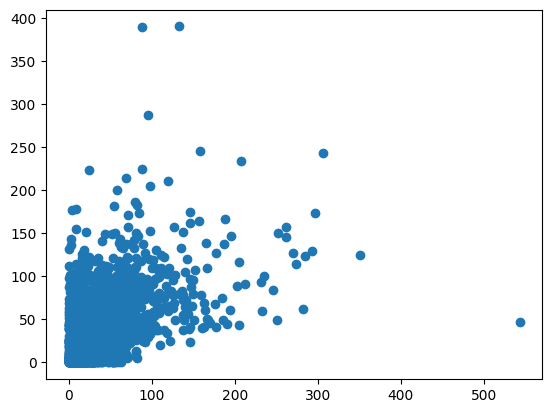

In [24]:
plt.scatter(df["station_precip_mm"], df["precipitation_amt_mm"])

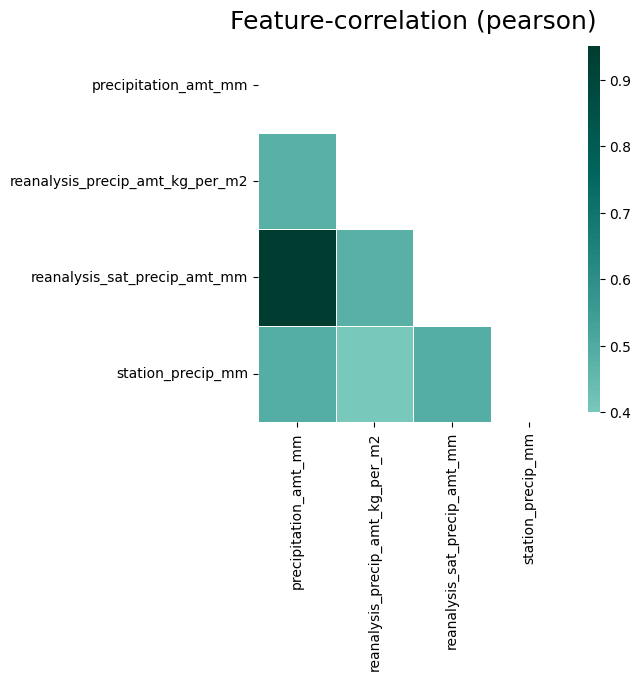

In [25]:
klib.corr_plot(df[precipitation], annot=False, figsize=(5, 5))
plt.show()

In [26]:
df["station_precip_mm"].fillna(df["precipitation_amt_mm"], inplace=True)

In [27]:
df[df[precipitation].isna().any(axis=1)]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_temp_rng_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
613,sj,1992,7,1992-02-12,0.131025,0.130500,0.195743,0.178857,NaN,297.798571,...,82.875714,NaN,16.060000,2.200000,26.028571,6.571429,32.2,20.0,1.3,65
614,sj,1992,8,1992-02-19,0.178599,0.184467,0.194614,0.203057,NaN,297.898571,...,77.295714,NaN,15.012857,2.585714,25.757143,7.385714,33.9,21.7,8.9,33
615,sj,1992,9,1992-02-26,0.107050,0.081500,0.165243,0.163057,NaN,297.472857,...,76.037143,NaN,14.381429,2.414286,25.285714,6.171429,29.4,21.7,16.0,38


To fill the remaining nulls, we note that there are only a few windows of missing data

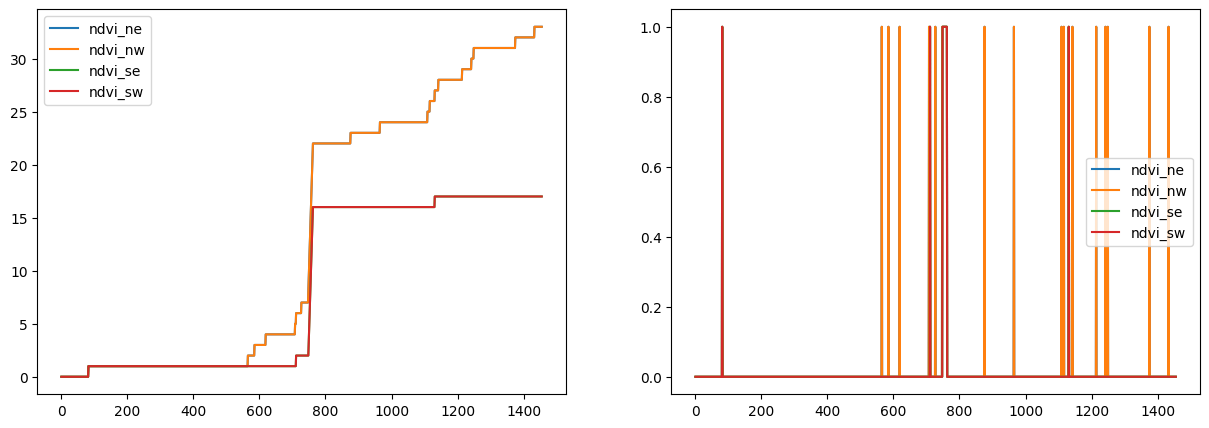

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df[vegetation].isna().cumsum().plot(ax=ax[0])
(df[vegetation].isna().cumsum() - df[vegetation].isna().cumsum().shift(1)).plot(ax=ax[1])
plt.show()

We linearly interpolate data where that is missing under a ceratin threshold. ALternatives:
- Regress on week number (however we are talkign about equatorial place, so no much seasonality)
- Knn 
- Don't want to spend much time

In [29]:
from dengue_prediction.preprocessing.cleaning import interpolate, find_null_window_size

In [30]:
df.isna().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  33
ndvi_nw                                  33
ndvi_se                                  17
ndvi_sw                                  17
precipitation_amt_mm                      3
reanalysis_air_temp_k                     0
reanalysis_avg_temp_k                     0
reanalysis_dew_point_temp_k               0
reanalysis_max_air_temp_k                 0
reanalysis_min_air_temp_k                 0
reanalysis_precip_amt_kg_per_m2           0
reanalysis_relative_humidity_percent      0
reanalysis_sat_precip_amt_mm              3
reanalysis_specific_humidity_g_per_kg     0
reanalysis_temp_rng_k                     0
station_avg_temp_c                        0
station_diur_temp_rng_c                   0
station_max_temp_c                        0
station_min_temp_c              

In [31]:
for col in df.columns[4:]:
    df = df.groupby("city", group_keys=False).apply(lambda x: interpolate(x, col))

In [32]:
df.isna().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  15
ndvi_nw                                  15
ndvi_se                                  14
ndvi_sw                                  14
precipitation_amt_mm                      0
reanalysis_air_temp_k                     0
reanalysis_avg_temp_k                     0
reanalysis_dew_point_temp_k               0
reanalysis_max_air_temp_k                 0
reanalysis_min_air_temp_k                 0
reanalysis_precip_amt_kg_per_m2           0
reanalysis_relative_humidity_percent      0
reanalysis_sat_precip_amt_mm              0
reanalysis_specific_humidity_g_per_kg     0
reanalysis_temp_rng_k                     0
station_avg_temp_c                        0
station_diur_temp_rng_c                   0
station_max_temp_c                        0
station_min_temp_c              

city
iq    Axes(0.125,0.11;0.775x0.77)
sj    Axes(0.125,0.11;0.775x0.77)
Name: ndvi_ne, dtype: object

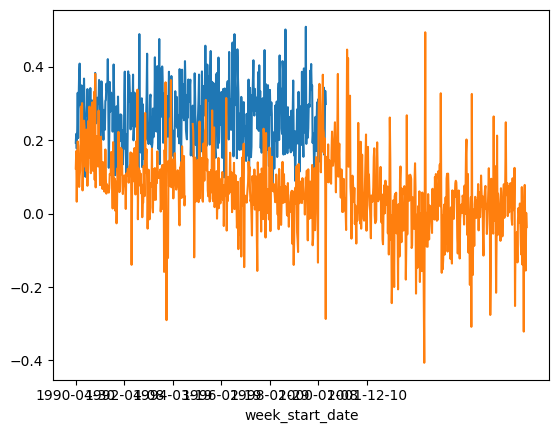

In [33]:
df.set_index("week_start_date").groupby("city")["ndvi_ne"].plot()

# Data correlation

In [34]:
from dengue_prediction.preprocessing.correlation import define_correlated_variable_groups

In [35]:
cols = df.columns[4:-1]
correlated_groups = define_correlated_variable_groups(df[cols], correlation_threshold=0.9)
correlated_groups

{'1': ['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm'],
 '2': ['reanalysis_dew_point_temp_k', 'reanalysis_specific_humidity_g_per_kg'],
 '3': ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k'],
 '4': ['reanalysis_max_air_temp_k', 'reanalysis_temp_rng_k']}

In [36]:
for k, v in correlated_groups.items():
    df.drop(v[1:], axis=1, inplace=True)  

# Preprocessing

In [37]:
from sklearn.preprocessing import RobustScaler

In [38]:
df.drop(["year", "week_start_date"],  axis=1, inplace=True)

In [39]:
# City 
df["city"] = (df["city"] == "iq").astype(int)

In [40]:
cols = df.columns[1:-1]

In [41]:
rs = RobustScaler()
df[cols] = rs.fit_transform(df[cols])

# Our starting point: the baseline model

A baseline model has been provided here: https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb

Relevant observations:
- This is a count prediction problem. Makes sense trying Poisson regression or Negative Binomial Regression. By inspection, labels mean != labels variance, therefore better try the latter
- Pearson correlation shows no strong correlations. Sign of correlation seems to have sense
- Fitted model shows weaknesses

To do:
- Null values
- Learning curve
- SIR model

In [42]:
from dengue_prediction.preprocessing.sklearn_wrapper_statsmodel import SMFormulaWrapper
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [43]:
df.dropna(inplace=True)

In [243]:
X = df.iloc[:, :-1].copy()
y = df["total_cases"].copy()

In [45]:
baseline_model_formula = "total_cases ~ 1 + " \
                "reanalysis_dew_point_temp_k + " \
                "station_min_temp_c + " \
                "station_avg_temp_c"

model = SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(), formula=baseline_model_formula)

In [46]:
from dengue_prediction.utils.plot_learning_curve import plot_learning_curve

<module 'matplotlib.pyplot' from '/Users/manueloffidani/Desktop/dengue_prediction/lib/python3.9/site-packages/matplotlib/pyplot.py'>

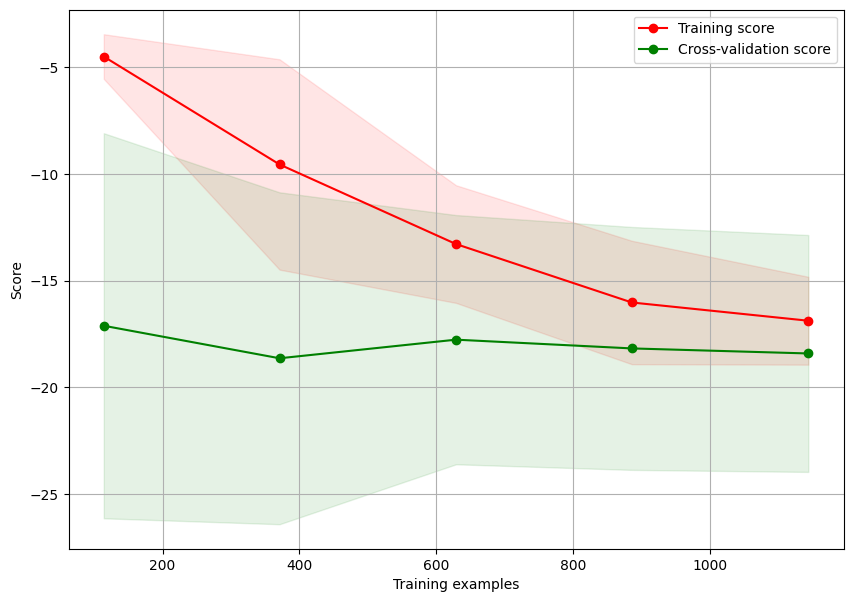

In [47]:
plot_learning_curve(estimator=model, X=X, y=y, scoring="neg_mean_absolute_error")

### Modified baseline model (full formula)

In [98]:
model_formula = "total_cases ~ 1 + " + " + ".join(list(df.columns[:-1]))

model = SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(), formula=model_formula)

<module 'matplotlib.pyplot' from '/Users/manueloffidani/Desktop/dengue_prediction/lib/python3.9/site-packages/matplotlib/pyplot.py'>

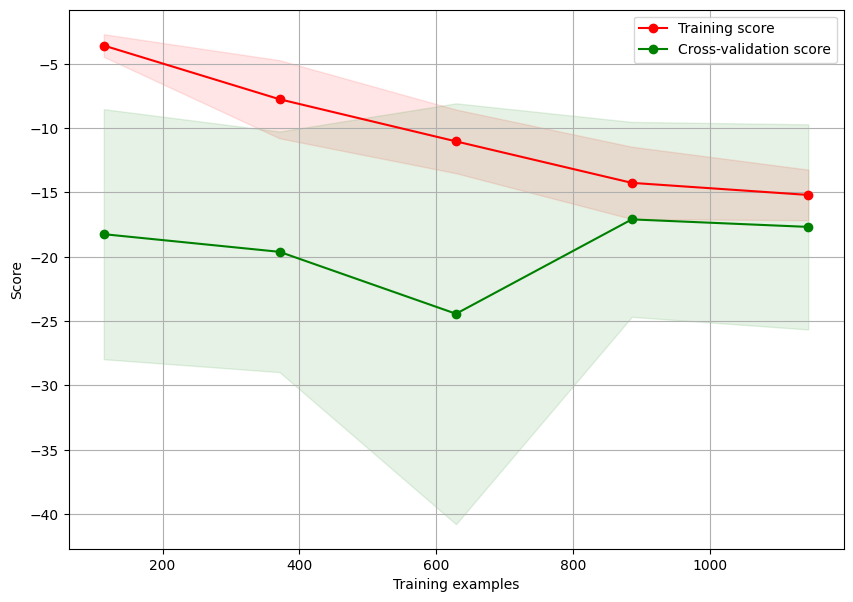

In [97]:
plot_learning_curve(estimator=model, X=X, y=y, scoring="neg_mean_absolute_error")

<module 'matplotlib.pyplot' from '/Users/manueloffidani/Desktop/dengue_prediction/lib/python3.9/site-packages/matplotlib/pyplot.py'>

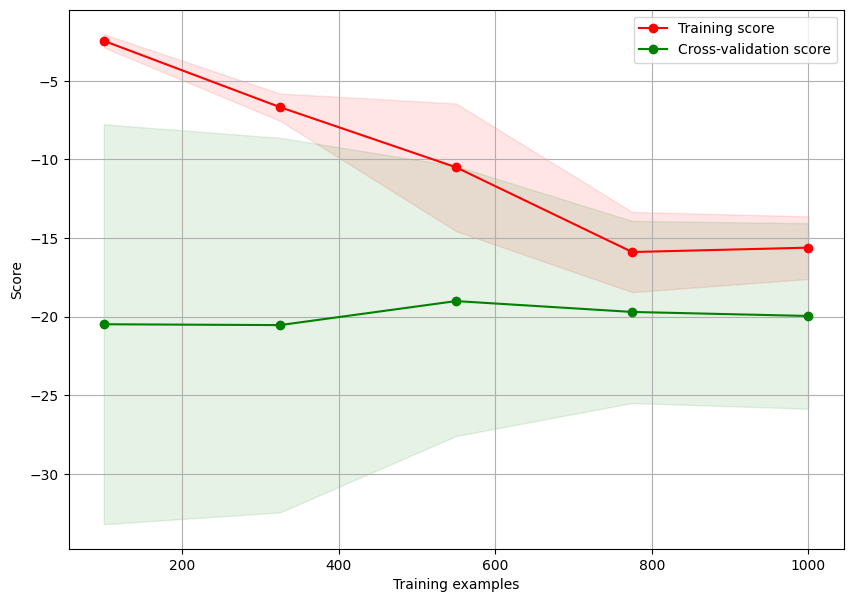

In [91]:
model = SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(), formula=model_formula)

In [ ]:
model.fit(X, y)

In [ ]:
Y = y.to_frame()
Y["city"] = X["city"]
Y["total_cases_pred"] = model.predict(X)

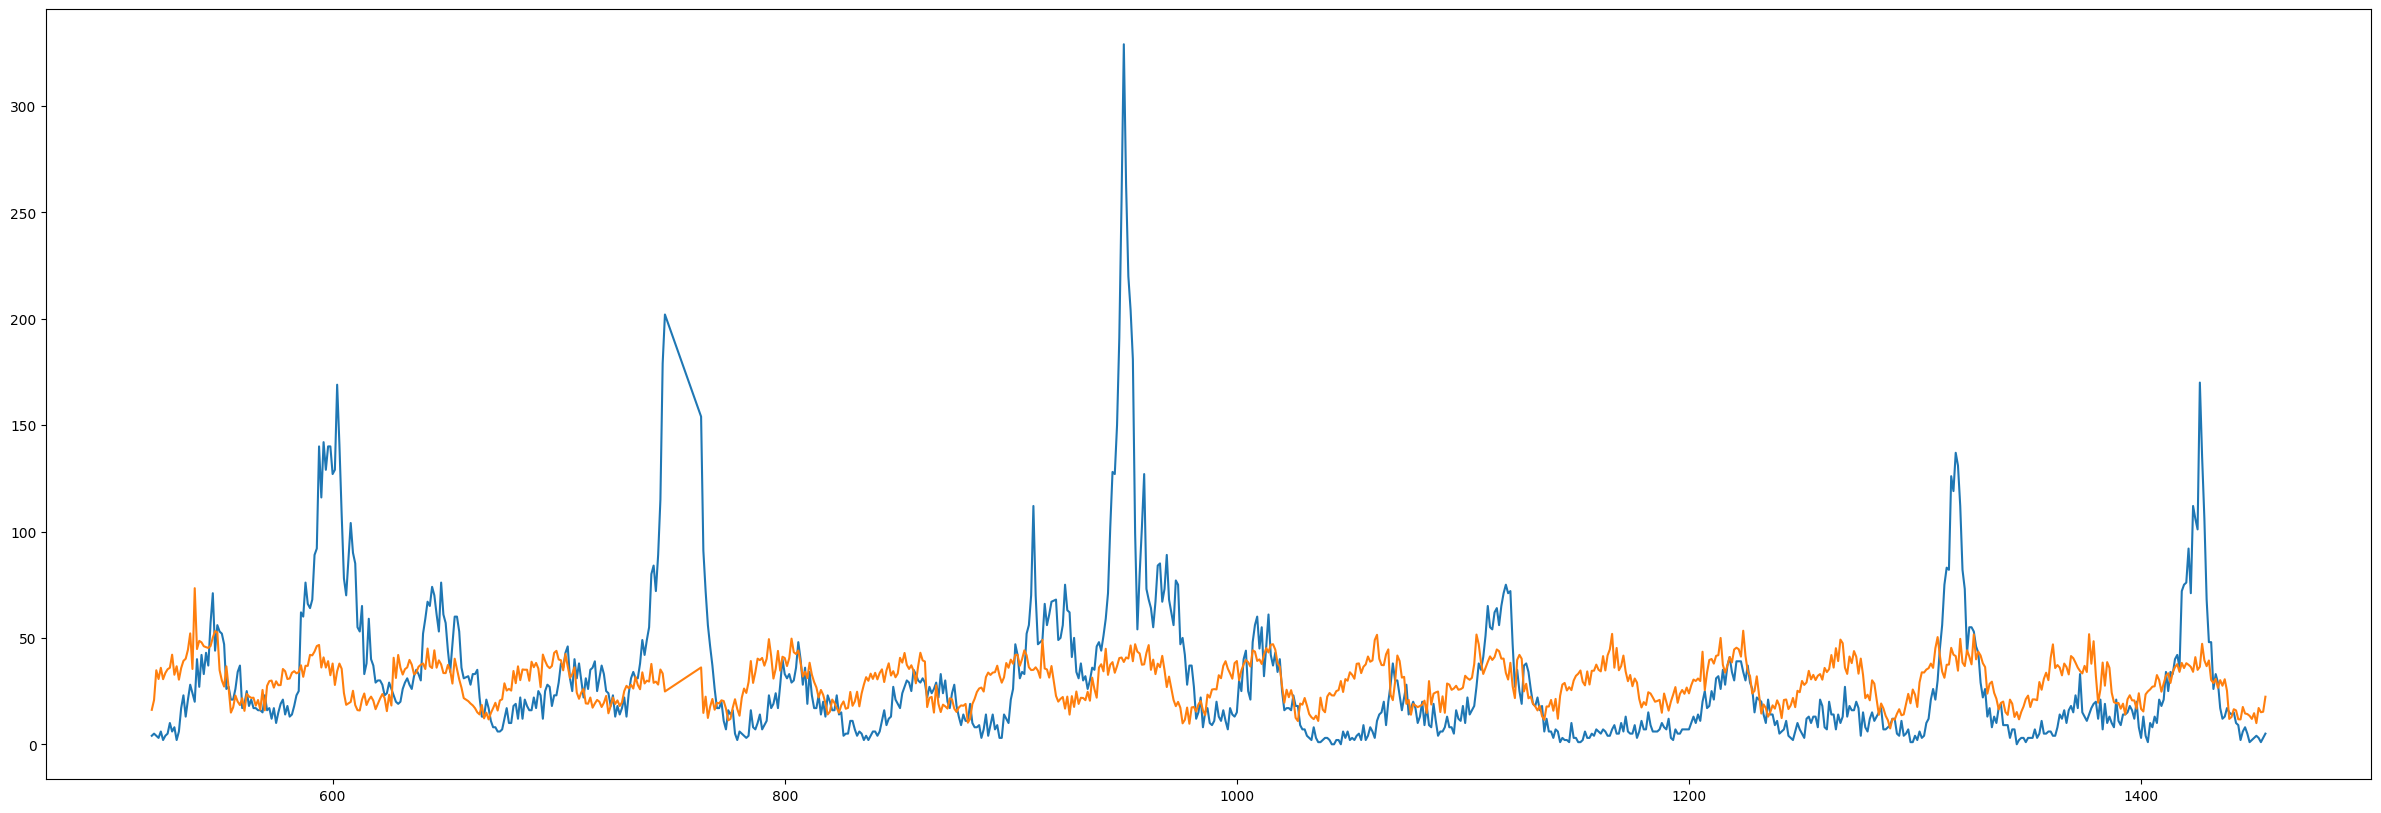

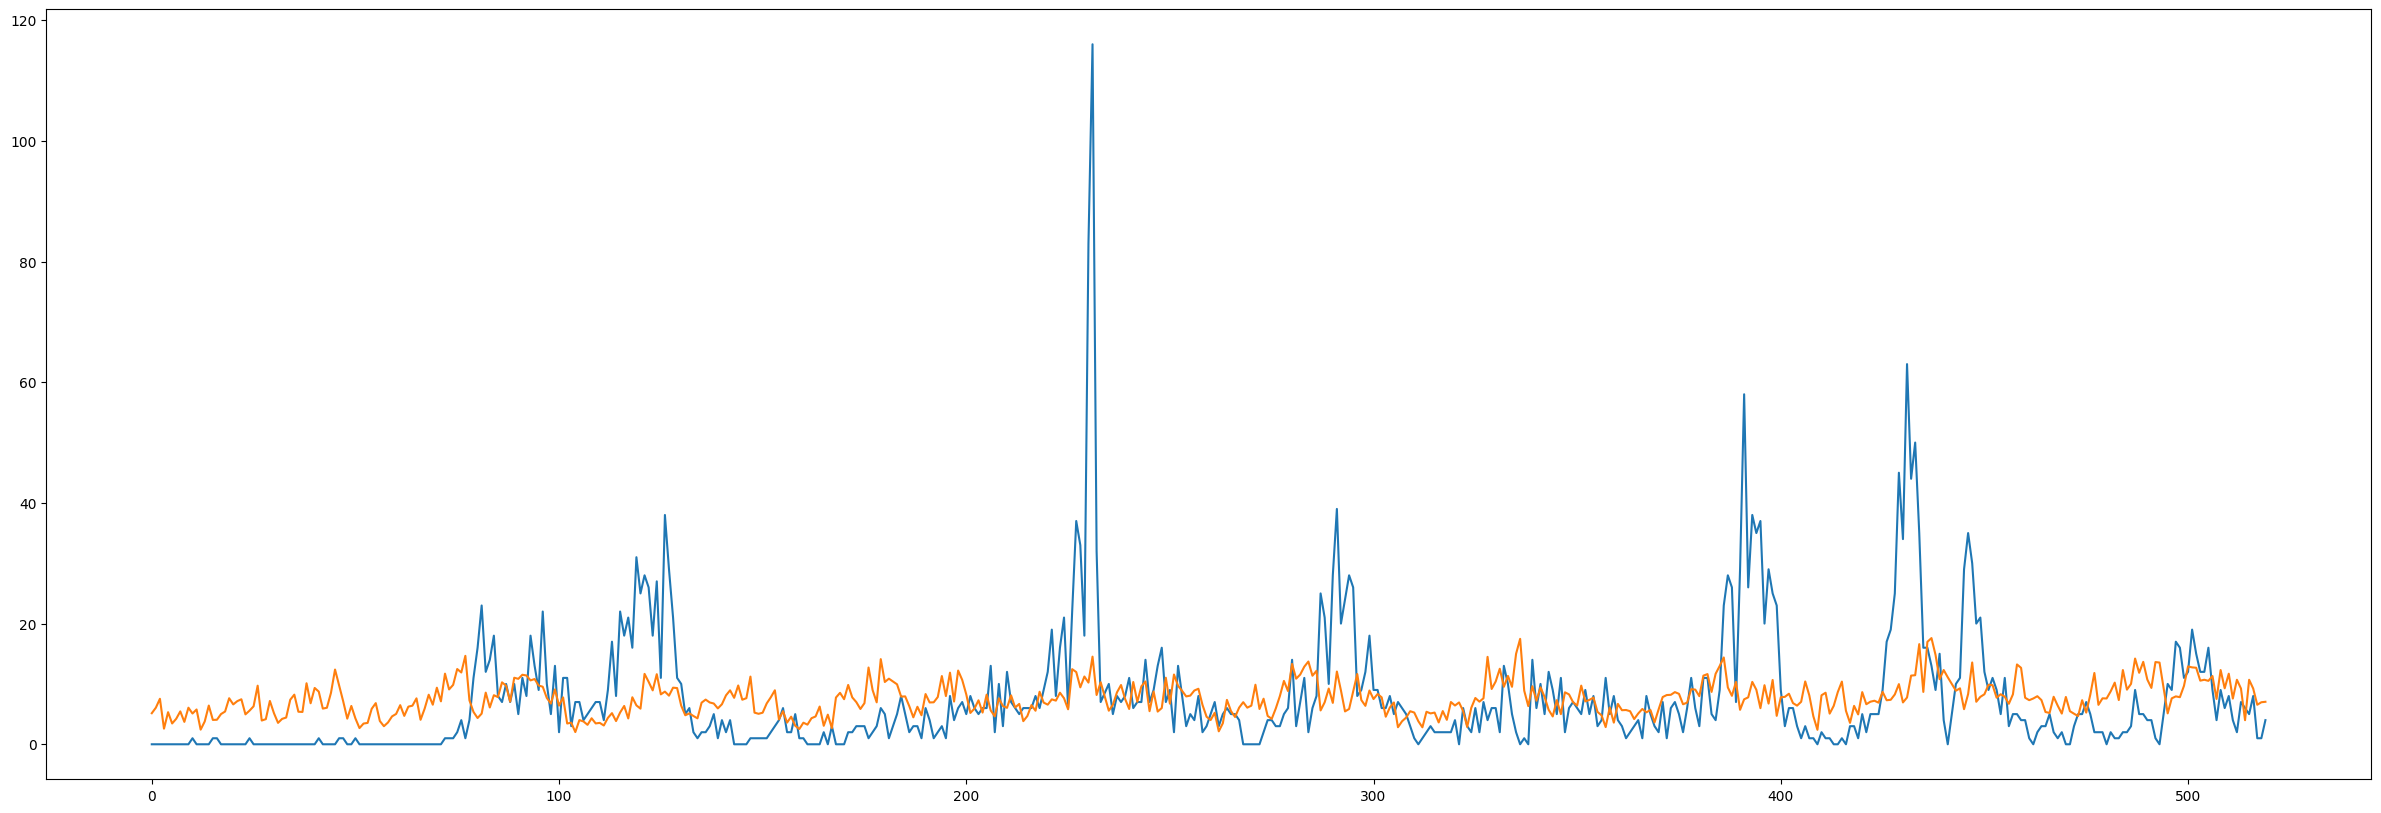

In [52]:
for c in range(2):   
    fig, ax = plt.subplots(figsize=(30, 10))
    Y[Y["city"] == c]["total_cases"].plot()
    Y[Y["city"] == c]["total_cases_pred"].plot()
    plt.show()

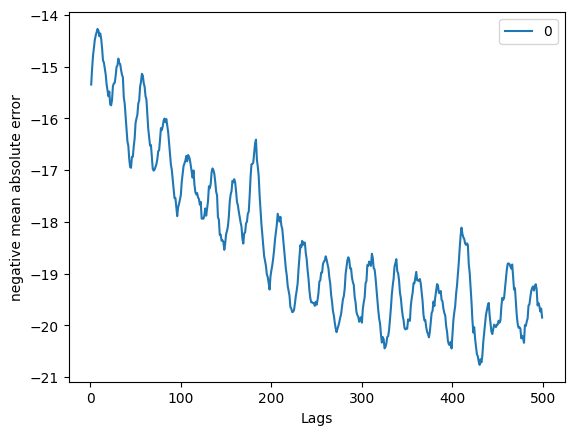

In [123]:
from dengue_prediction.training.utils import lag_training_scores

scores = lag_training_scores(base_model=SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(), formula=model_formula), X=X, y=y, N=500)

pd.DataFrame.from_dict(scores, orient="index").plot()
plt.ylabel("negative mean absolute error")
plt.xlabel("Lags")
plt.show()

# Time series properties 

In [156]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

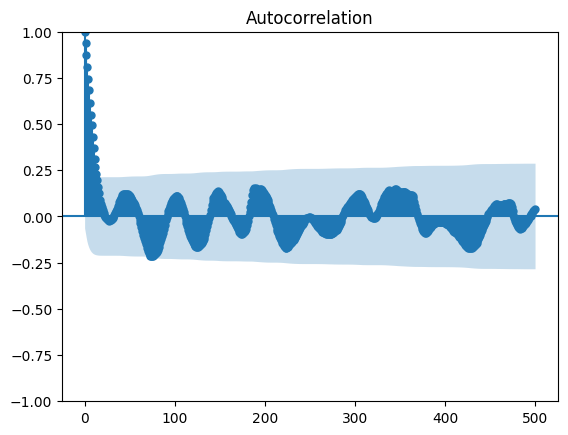

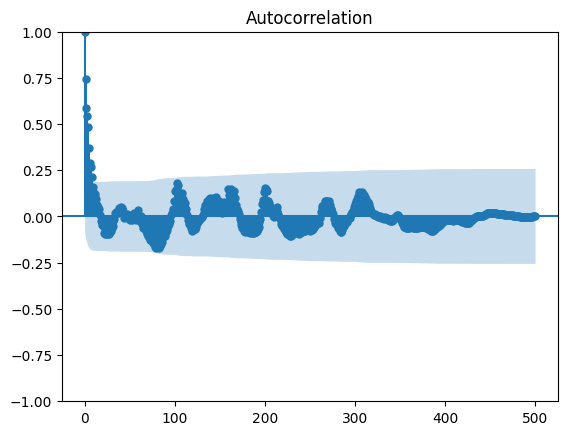

In [150]:
plot_acf(Y[Y["city"] == 0]["total_cases"], lags=500)
plot_acf(Y[Y["city"] == 1]["total_cases"], lags=500)
plt.show()



In [169]:
from scipy.signal import argrelextrema

In [191]:
argrelextrema(acf(Y[Y["city"] == 0]["total_cases"], nlags=500), np.greater)

(array([ 28,  46, 102, 148, 188, 190, 196, 250, 271, 273, 305, 338, 346,
        355, 363, 390, 396, 402, 458, 466, 470]),)

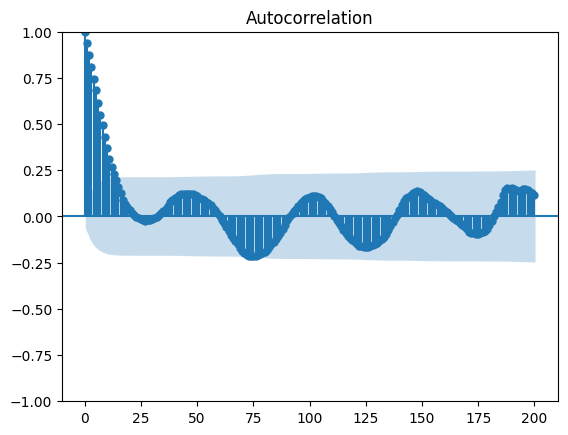

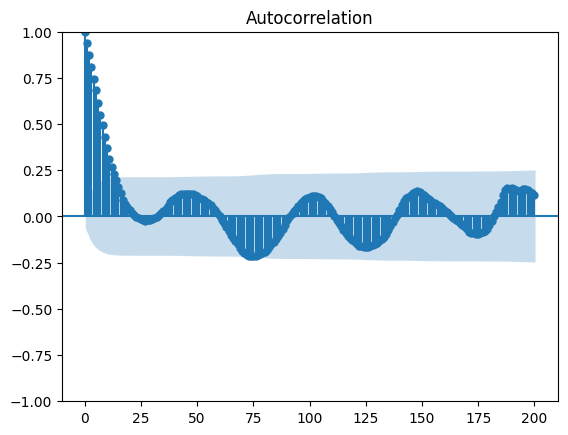

In [194]:
plot_acf(Y[Y["city"] == 0]["total_cases"], lags=200)

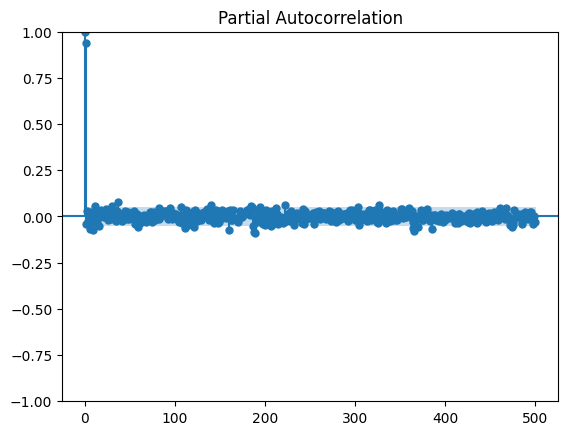

In [ ]:
plot_pacf(Y["total_cases"], method="ywm", lags=500)
plt.show()

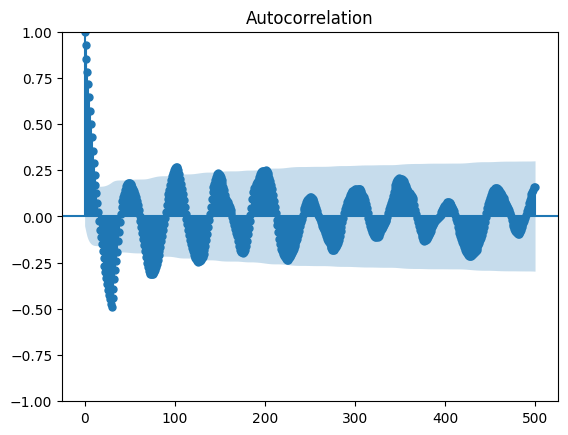

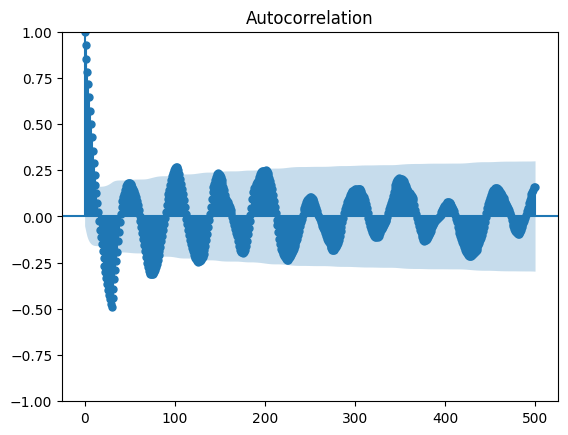

In [ ]:
plot_acf(Y["total_cases"].diff(periods=30).dropna(), lags=500)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

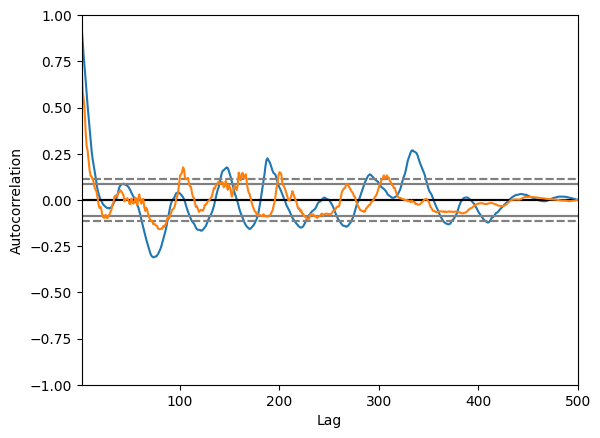

In [ ]:
autocorrelation_plot(Y[Y.city == 0]["total_cases"][:500])
autocorrelation_plot(Y[Y.city == 1]["total_cases"][:500])

Dicky Fuller test to check stationarity does not make se

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller()

In [214]:
Y.groupby("city")["total_cases"].apply(lambda x: adfuller(x, autolag='AIC', regression='ct', maxlag=100)).apply(lambda x: x[1])

city
0    3.030942e-07
1    1.613744e-06
Name: total_cases, dtype: float64

In [211]:
ad_fuller = {}
for c in X.columns[2:-1]:
    ad_fuller[c] = X.groupby("city")[c].apply(lambda x: adfuller(x, autolag='AIC', regression='ctt', maxlag=60)).apply(lambda x: x[1])

In [212]:
pd.DataFrame(ad_fuller).T  > 0.05

city,0,1
ndvi_ne,False,False
ndvi_nw,False,False
ndvi_se,False,False
ndvi_sw,False,False
precipitation_amt_mm,False,True
reanalysis_air_temp_k,False,True
reanalysis_dew_point_temp_k,False,True
reanalysis_max_air_temp_k,False,True
reanalysis_min_air_temp_k,False,False
reanalysis_precip_amt_kg_per_m2,False,False


Arima computationally very expensive

In [225]:
from statsmodels.tsa.arima.model import ARIMA

def predict_arima(train, n_predictions):
    
    predictions = []
    history = [x for x in train]
    
    for t in range(n_predictions):
        arima = ARIMA(history, order=(1,1,10))
        model_fit = arima.fit()
        output = model_fit.forecast()
        yhat = int(output[0])
        predictions.append(yhat)
        history.append(yhat)
       
    return predictions

In [226]:
A = Y[Y.city == 0]["total_cases"].values
size = int(len(A) * 0.66)
train = A[0:size]
test = A[size:]

preds = predict_arima(A, len(test))

0
1
2
3



KeyboardInterrupt



In [ ]:
plt.plot(preds)

We have all stationary features, and for this reason, plus the fact that we don't have a huge amount of data, we are going to create lag features rather than using NN models such as LSTM able to capture 

**Also to have a useful model, a model that predicts just for the next week is not that helpful (USAGE??) . We have to options:** 

1. Predict future features 
2. Predict multiple labels

# Create lagged features 

In [300]:
from dengue_prediction.training.lags import create_training_sets

In [303]:
_X, _y = create_training_sets(df, lag=60, pred_lag=1)

In [304]:
_X.shape

(1310, 1038)

In [284]:
_X = _X.dropna()
_y = y.loc[_X.index]

In [285]:
from sklearn.linear_model import Lasso

In [286]:
lasso = Lasso()

In [287]:
X.shape

(1431, 18)

In [288]:
lasso.fit(_X, _y)

Lasso()

In [289]:
C = pd.DataFrame({"features": _X.columns, "coef": lasso.coef_})

In [290]:
C[C["coef"] != 0]

,features,coef
13,station_avg_temp_c,0.256728
57,ndvi_ne_lag_40,0.076719
59,ndvi_ne_lag_42,0.454136
60,ndvi_ne_lag_43,0.193084
61,ndvi_ne_lag_44,0.076903
...,...,...
911,station_precip_mm_lag_9,-0.398058
912,station_precip_mm_lag_10,-0.170212
913,station_precip_mm_lag_11,-0.105489
923,station_precip_mm_lag_21,-0.160008


In [291]:
features = list(C[C["coef"] != 0]["features"].unique())

In [296]:
model_formula = "total_cases ~ 1 + " + " + ".join(features)

model = SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(alpha=0.001), formula=model_formula)

(-30.0, 0.0)

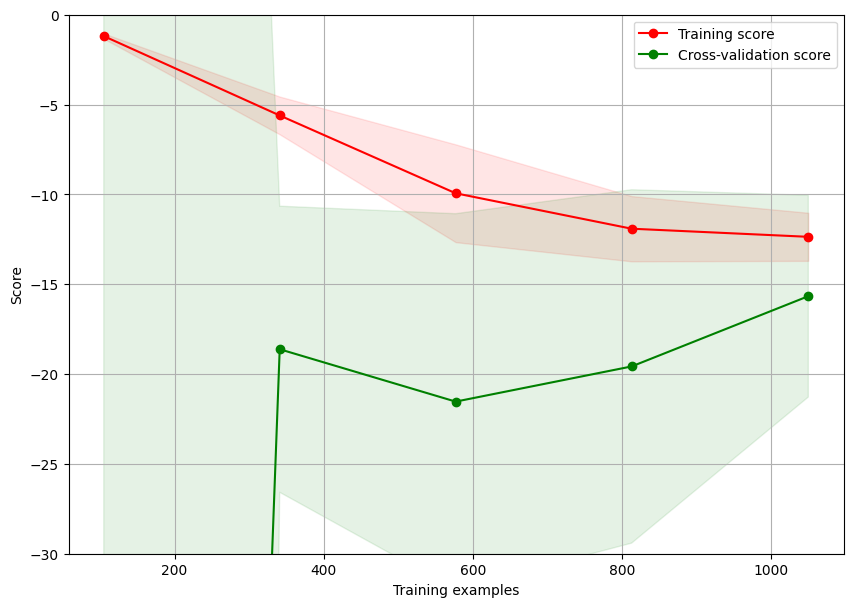

In [297]:
plot_learning_curve(estimator=model, X=_X, y=_y, scoring="neg_mean_absolute_error")
plt.ylim(-30, 0)

In [472]:
from dengue_prediction.training.lags import get_preds_lagged_model

In [481]:
preds, y, lc, uc = get_preds_lagged_model(df, lag=30, pred_lag=1)

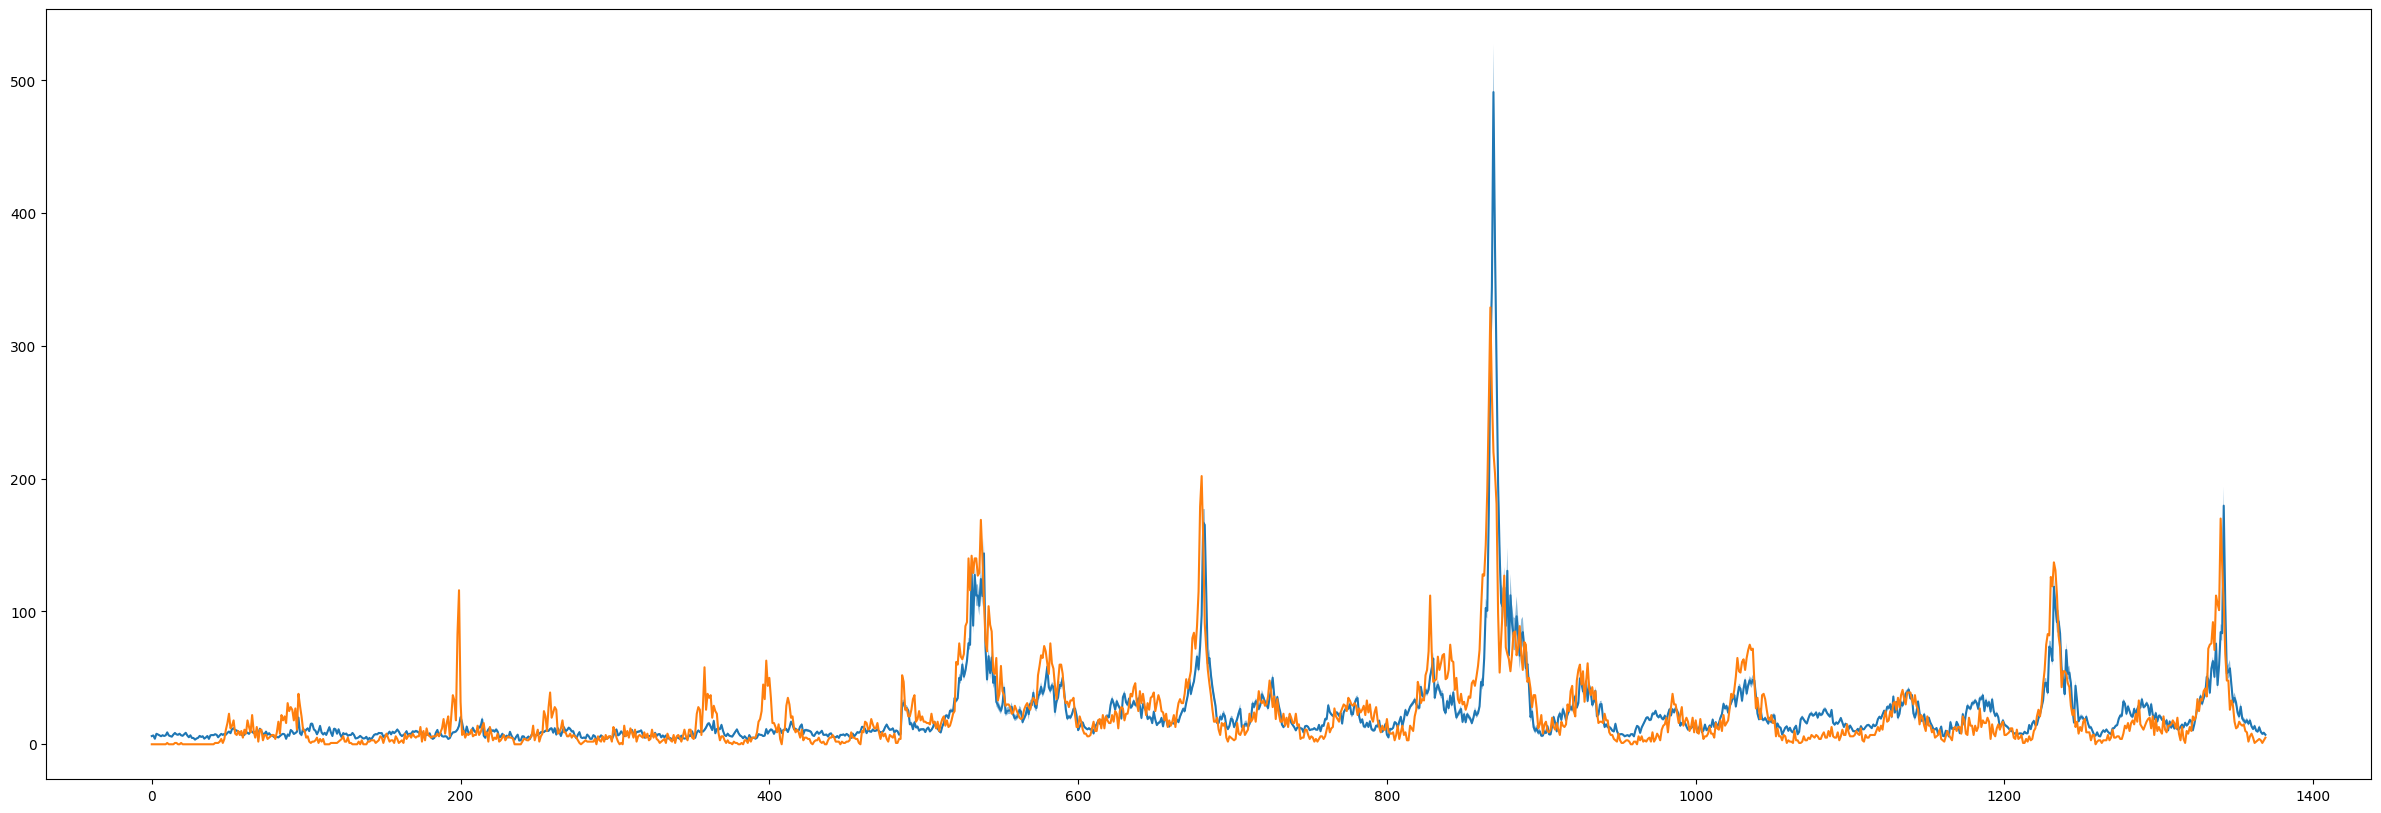

In [482]:
plt.figure(figsize=(30, 10))
plt.plot(preds)
plt.plot(y)
plt.fill_between(range(len(lc)), lc, uc, alpha=0.5)


In [483]:
from sklearn.metrics import mean_absolute_error

In [484]:
mean_absolute_error(y, preds)

10.079172678388433

In [364]:
maes = []
for pl in range(1, 52):
    if pl % 10 == 0:
        print(pl, end="...")
    maes.append(get_metrics_lagged_model(df, lag=30, pred_lag=pl))

AttributeError: 'SMFormulaWrapper' object has no attribute 'get_prediction'

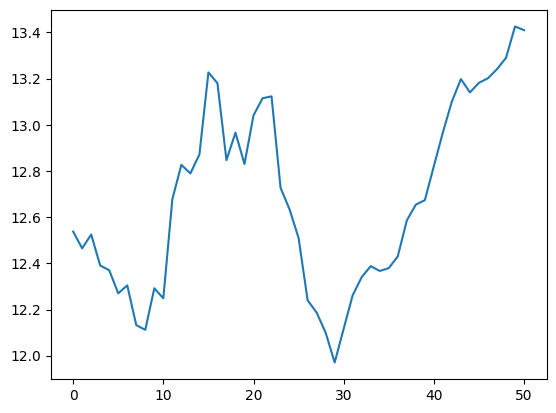

In [362]:
plt.plot(maes)